In [4]:
##  LIBRERIAS  
import os
import numpy as np
import pandas as pd
import re
from unidecode import unidecode
from tqdm.notebook import trange, tqdm
import time
import math

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

from mpl_toolkits import mplot3d
%matplotlib inline

In [5]:
## LECTURA ... Df Parametros
par_file_name="CLAG1.par"

#print(open(par_file_name, "r").read())
open(par_file_name, "r").close()
l=[re.split("[']", x) for x in open(par_file_name, "r")]
#print(x)
open(par_file_name, "r").close()            #cerrar archivo 
## diccionario de parámetros
param={}
param_l=[]
paran_v=[]

## OJO!! 
# Separador no es el mismo en todos los SO -->  Usar OS

## header:          PARÁMETRO 1
param[1]=l[0][0].strip()
param_l.append(l[0][1].strip().replace(os.sep,""))
## input file:          PARÁMETRO 2
param[2]=l[1][0].strip().rsplit(os.sep, 1)[-1]
param_l.append(l[1][1].strip().replace(os.sep,""))
## columns for data:          PARÁMETRO 3
param[3]=[int(x) for x in l[2][0].strip().split(",")]
param_l.append(l[2][1].strip().replace(os.sep,"")[0:16])
## initial search volume:          PARÁMETRO 4
param[4]=[float(x) for x in l[3][0].strip().split(",")]
param_l.append(l[3][1].strip().replace(os.sep,""))
## Number of Risk Thresholds:          PARÁMETRO 5
param[5]=[int(x) for x in l[4][0].strip().split(",")]
param_l.append(l[4][1].strip().replace(os.sep,"")[0:37])
## Selected risk thresholds:          PARÁMETRO 6
param[6]=[float(x) for x in l[5][0].strip().split(",")]
param_l.append(l[5][1].strip().replace(os.sep,""))
## Number of data in local volume:          PARÁMETRO 7
param[7]=[int(x) for x in l[6][0].strip().split(",")]
param_l.append(l[6][1].strip().replace(os.sep,""))
## Number of units:          PARÁMETRO 8
param[8]=[int(x) for x in l[7][0].strip().split(",")]
param_l.append(l[7][1].strip().replace(os.sep,""))
## Unit names:          PARÁMETRO 9
param[9]=[int(x) for x in l[8][0].strip().split(",")]
param_l.append(l[8][1].strip().replace(os.sep,""))
## not consider values less than:          PARÁMETRO 10
param[10]=[int(x) for x in l[9][0].strip().split(",")]
param_l.append(l[9][1].strip().replace(os.sep,""))
## output files name:          PARÁMETRO 11
param[11]=l[10][0].strip().rsplit(os.sep, 1)[-1]
param_l.append(l[10][1].strip().replace(os.sep,""))
## number of zones:          PARÁMETRO 12
param[12]=[int(x) for x in l[11][0].strip().split(",")]
param_l.append(l[11][1].strip().replace(os.sep,""))
## zone identifiers:          PARÁMETRO 13
param[13]=[int(x) for x in l[12][0].strip().split(",")]
param_l.append(l[12][1].strip().replace(os.sep,""))
## azimuth of search orientation per zone :          PARÁMETRO 14
param[14]=[int(x) for x in l[13][0].strip().split(",")]
param_l.append(l[13][1].strip().replace(os.sep,""))
## Anisotropy ratios:          PARÁMETRO 15
param[15]=[float(x) for x in l[14][0].strip().split(",")]
param_l.append(l[14][1].strip().replace(os.sep,""))
## Exclude data from the same drillhole:          PARÁMETRO 16
param[16]=[int(x) for x in l[15][0].strip().split(",")]
param_l.append(l[15][1].strip().replace(os.sep,""))
## Option to weight data by search expansion:          PARÁMETRO 17
param[17]=[int(x) for x in l[16][0].strip().split(",")]
param_l.append(l[16][1].strip().replace(os.sep,""))

df_parametros = pd.DataFrame(list(zip(list(range(1,18)), param_l, list(param.values()))),
                            columns=['Orden','Descripcion', 'Valor']
                        )


df_parametros






,Orden,Descripcion,Valor
0,1,header,Capping Test Copper Using BHID
1,2,input file,CLAG_MR2022_2.csv
2,3,columns for data,"[1, 2, 3, 4, 6, 5, 7, 8]"
3,4,initial search volume,"[30.0, 30.0, 30.0]"
4,5,Number of Risk Thresholds to consider,[6]
5,6,selected risk thresholds,"[0.1, 0.125, 0.15, 0.175, 0.2, 0.225]"
6,7,number of data in local volume,[21]
7,8,number of units,[2]
8,9,unit names,"[31, 32]"
9,10,do not consider values less than,[0]


In [6]:
##   Lectura CSV compositos .. validar si hay nulos o no

df_CLAG_MR_2022 = pd.read_csv(param[2])
df_CLAG_MR_2022.head(2)
## Requerimiento: No NaN ni missing values
'''
Algoritmo localcapping no admite valores nulos ni missings
función missing_val(df) identifica casos missing y nulos
'''

def missing_val(df):
    cero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mz_table = pd.concat([cero_val, mis_val], axis=1)
    mz_table = mz_table.rename(
               columns = {0 : 'Valores  Cero', 1 : 'Valores Missing'})
    mz_table['Total Cero + Missing'] = mz_table['Valores  Cero'] + mz_table['Valores Missing']
    mz_table = mz_table[mz_table.iloc[:,1] != 0].round(1)
    print ("Df Columnas: " + str(df.shape[1]) + " Df Filas: " + str(df.shape[0]) + " \n"      
            "Columnas con Ceros / Missing: " + str(mz_table.shape[0]))
    return mz_table

## 
missing_val(df_CLAG_MR_2022)  




Df Columnas: 8 Df Filas: 4255 
Columnas con Ceros / Missing: 0


,Valores Cero,Valores Missing,Total Cero + Missing


In [7]:
df_CLAG_MR_2022.head(2)

,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID
0,2336,4072.2950,4850.2450,4199.8669,25.146513,32,42,A019
1,2337,4073.5668,4848.7522,4196.7885,40.000000,31,42,A019


In [8]:
# ACONDICIONAR DATAFRAME


'''
Este ordenamiento no limita la seleccion decolumnas por nombre
Hace seleccion en funcion del orden inicial de columnas
'''
df_CLAG_MR_2022_R=df_CLAG_MR_2022[[df_CLAG_MR_2022.iloc[:,0].name,
                                   df_CLAG_MR_2022.iloc[:,1].name,
                                   df_CLAG_MR_2022.iloc[:,2].name,
                                   df_CLAG_MR_2022.iloc[:,3].name,
                                   df_CLAG_MR_2022.iloc[:,4].name,
                                   df_CLAG_MR_2022.iloc[:,5].name,
                                   df_CLAG_MR_2022.iloc[:,6].name,
                                   df_CLAG_MR_2022.iloc[:,7].name]]

df_CLAG_MR_2022=df_CLAG_MR_2022_R

df_CLAG_MR_2022.head(2)


##  $$$  INICILIZAR VALORES PARA 6 UMBRALES
##  y    #ID,BHID,X,Y,Z,CODE,ZONE,VALUE,CAPVAL1,CAPPED1,CAPVAL2,CAPPED2,CAPVAL3,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6
#         ,AvgSin,PROP_12,Num_Data

df_CLAG_MR_2022["CAPVAL1"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED1"]=0
df_CLAG_MR_2022["CAPVAL2"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED2"]=0
df_CLAG_MR_2022["CAPVAL3"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED3"]=0
df_CLAG_MR_2022["CAPVAL4"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED4"]=0
df_CLAG_MR_2022["CAPVAL5"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED5"]=0
df_CLAG_MR_2022["CAPVAL6"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED6"]=0

df_CLAG_MR_2022["AvgSin"]=0
df_CLAG_MR_2022["PROP_12"]=0
df_CLAG_MR_2022["Num_Data"]=0

df_CLAG_MR_2022.head(2)




,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1,CAPPED1,...,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6,AvgSin,PROP_12,Num_Data
0,2336,4072.2950,4850.2450,4199.8669,25.146513,32,42,A019,25.146513,0,...,0,25.146513,0,25.146513,0,25.146513,0,0,0,0
1,2337,4073.5668,4848.7522,4196.7885,40.000000,31,42,A019,40.000000,0,...,0,40.000000,0,40.000000,0,40.000000,0,0,0,0


In [9]:
df_parametros.Valor[12]

[41, 42]

In [42]:

breaker=0
iterador=0


#for zone in df_parametros.Valor[12][:1]:     ## borrar   [:2]
zonas = df_parametros.Valor[12]
for zone in zonas:     #################################  FIJO PARA PRUEBA  BORRAR
    
    print("\n\n")
    print("zone:",zone)
    print(" ") 
    #  df_parametros.Valor[13]         ## LISTA DE AZIMUTH
    print("azimuth:",df_parametros.Valor[13][iterador])
    azimuth=df_parametros.Valor[13][iterador]
    cartesiana=0          ## <------ 

    if azimuth < 90:
        cartesiana=90-azimuth 
    elif azimuth < 180:
        cartesiana=360-(azimuth-90) 
    elif azimuth < 270:
        cartesiana=270-(azimuth-180) 
    elif azimuth < 360:
        cartesiana=180-(azimuth-270) 
        
    print("cartesiana:",cartesiana)
    rad=math.radians(cartesiana)    ## <------  APLICAR ACA SIN COS etc etc    
    print("radian:",rad)
    #df_parametros.Valor[14]                            ## LISTA DE ANISOTROPIA 
    print("ratio anisotropia:",df_parametros.Valor[14][iterador])
    ratio=df_parametros.Valor[14][iterador]
    
    ###for rock in df_parametros.Valor[8][:1]:## borrar   [3]
    rocks=df_parametros.Valor[8]
    for rock in rocks:

        freno_1_composito_x_roca=0

        print("\n\n\n")
        print("    rock:",rock)
        print("    zone:",zone)
        print(" ")
        print("    parametros de la Roca ")
        print("    ratio anisotropia:",ratio)
        semi_x=(df_parametros.Valor[3][1] / 2)
        semi_y=((df_parametros.Valor[3][2]*ratio) / 2)
        print("    semi_x: ",semi_x,"\n    semi_y: ",semi_y)
        print("    azimuth: ",azimuth)
        print("    cartesiana: ",cartesiana)
        print("    radian: ",rad)
        

        for obs in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:  ## ITERAR INDICES
            print("\n")
            print("        index:",obs)
            print(" ")
            x=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,1][obs]
            y=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,2][obs]
            z=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,3][obs]
             
            print("        x: ",x)
            print("        y: ",y)
            print("        z: ",z)         
            x_SI,y_SI= x - semi_x,y + semi_y        
            x_II,y_II= x - semi_x,y - semi_y
            x_SD,y_SD= x + semi_x,y + semi_y
            x_ID,y_ID= x + semi_x,y - semi_y      
            print("        SI:",x_SI,y_SI)
            print("        II:",x_II,y_II)  
            print("        SD:",x_SD,y_SD) 
            print("        ID:",x_ID,y_ID)

            s = gpd.GeoSeries([Polygon([(x_II,y_II), (x_SI, y_SI), (x_SD, y_SD), (x_ID, y_ID)])])      
            ## RESPETAR ORDEN II SI SD ID
            #s[0]
            #s.rotate(cartesiana, origin=(x,y))[0]
            rx,ry = s.rotate(  cartesiana, origin=(x,y))[0].exterior.coords.xy
            coords = np.dstack((rx,ry)).tolist()
            #print(coords)           
            print("        Rotated coords: ")
            print("        ",coords[0][0][0],coords[0][0][1])
            print("        ",coords[0][1][0],coords[0][1][1])
            print("        ",coords[0][2][0],coords[0][2][1])
            print("        ",coords[0][3][0],coords[0][3][1])
            print("        ",coords[0][4][0],coords[0][4][1])

            ley=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,4][obs]
            print("        ley: ",ley)

            rotado2d=s.rotate(cartesiana, origin=(x,y))[0]
            index_inner_3d=[]## INDICES EN POLIGONO ROTADO 3D  
            index_inner_3d.append(obs)         

            for obs_sub in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T: 
                print(" ")             
                print("            obs    : ",obs)
                print("            obs_sub: ",obs_sub)
                sub_ley=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,4][obs_sub]
                print("            ley_sub: ",sub_ley)
                x_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][1]
                y_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][2]
                print("            x_sub: ",x_int)
                print("            y_sub: ",y_int)
                
                composito_inter= gpd.GeoSeries([Point(x_int,y_int)])
                
                if rotado2d.intersects(composito_inter[0]) == True:
                    print("            Sub_indice dentro del poligono rotado 2D")
                    z_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][3]
                    print("                    z_sub: ",z_int)
                    
                    print("                    ",z)
                    print("                    ",z_int)
                    print("                    ",abs(z-z_int))

                else:
                    print("            NO Sub_indice FUERA del poligono rotado 2D")


            




            freno_1_composito_x_roca=freno_1_composito_x_roca+1
            if freno_1_composito_x_roca>0:
                break



    print(" ")
    print(" ")







zone: 41
 
azimuth: 140
cartesiana: 310
radian: 5.410520681182422
ratio anisotropia: 2.5




    rock: 31
    zone: 41
 
    parametros de la Roca 
    ratio anisotropia: 2.5
    semi_x:  15.0 
    semi_y:  37.5
    azimuth:  140
    cartesiana:  310
    radian:  5.410520681182422


        index: 73
 
        x:  3185.3567
        y:  4329.8712
        z:  4116.0064
        SI: 3170.3567 4367.3712
        II: 3170.3567 4292.3712
        SD: 3200.3567 4367.3712
        ID: 3200.3567 4292.3712
        Rotated coords: 
         3146.98821923774 4317.257331283538
         3204.4415524716633 4365.466402010029
         3223.7251807622597 4342.48506871646
         3166.2718475283364 4294.275997989969
         3146.98821923774 4317.257331283538
        ley:  0.828571
            obs    :  73
            obs_sub:  73
            ley_sub:  0.828571
            x_sub:  3185.3567
            y_sub:  4329.8712
            obs    :  73
            obs_sub:  74
            ley_sub:  2.0
         

In [27]:
rx,ry = s.rotate(  cartesiana, origin=(x,y))[0].exterior.coords.xy

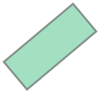

In [43]:
s.rotate(cartesiana, origin=(x,y))[0]